# Code Comment Classification - Data Cleaning

This notebook performs basic data cleaning for the code comment classification dataset.

## Cleaning Steps:
1. Load the dataset
2. Check for missing values and data quality
3. Remove duplicates
4. Filter to actual labeled data (instance_type=1)
5. Remove redundant columns (instance_type and partition)
6. Analyze the cleaned dataset
7. Save cleaned data

## 1. Import Required Libraries

In [49]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', 100)

print("Libraries imported successfully!")

Libraries imported successfully!


## 2. Load Dataset

In [50]:
# Load the dataset
df = pd.read_csv('code-comment-classification.csv')

print(f"Dataset shape: {df.shape}")
print(f"\nColumns: {df.columns.tolist()}")
print(f"\nFirst 10 rows:")
df.head(10)

Dataset shape: (12775, 6)

Columns: ['comment_sentence_id', 'class', 'comment_sentence', 'partition', 'instance_type', 'category']

First 10 rows:


,comment_sentence_id,class,comment_sentence,partition,instance_type,category
0,1,AccessMixin,abstract cbv mixin that gives access mixins the same customizable,0,0,Usage
1,2,AccessMixin,functionality.,1,0,Usage
2,5,AmbiguityError,more than one migration matches a name prefix.,0,0,Usage
3,7,AppConfigStub,stub of an appconfig.,1,0,Usage
4,8,AppConfigStub,only provides a label and a dict of models.,0,0,Usage
5,520,MigrationGraph,"a node should be a tuple app path, migration name .",1,0,Usage
6,11,Archive,the external api class that encapsulates an archive implementation.,0,0,Usage
7,14,ArchiveIndexView,top level archive of date based items.,1,0,Usage
8,16,Atomic,guarantee the atomic execution of a given block.,0,0,Usage
9,538,MigrationLoader,load migration files from disk and their status from the database.,1,0,Usage


## 3. Data Quality Checks

In [51]:
# Check data types
print("Data types:")
print(df.dtypes)
print(f"\n{'='*60}\n")

# Check for missing values
print("Missing values per column:")
print(df.isnull().sum())
print(f"\n{'='*60}\n")

# Dataset info
print("Dataset info:")
df.info()

Data types:
comment_sentence_id     int64
class                  object
comment_sentence       object
partition               int64
instance_type           int64
category               object
dtype: object


Missing values per column:
comment_sentence_id    0
class                  0
comment_sentence       0
partition              0
instance_type          0
category               0
dtype: int64


Dataset info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12775 entries, 0 to 12774
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   comment_sentence_id  12775 non-null  int64 
 1   class                12775 non-null  object
 2   comment_sentence     12775 non-null  object
 3   partition            12775 non-null  int64 
 4   instance_type        12775 non-null  int64 
 5   category             12775 non-null  object
dtypes: int64(3), object(3)
memory usage: 599.0+ KB


In [52]:
# Check for null or empty comments
null_comments = df['comment_sentence'].isnull().sum()
empty_comments = (df['comment_sentence'].str.strip() == '').sum()

print(f"Null comments: {null_comments}")
print(f"Empty comments: {empty_comments}")
print(f"Total problematic comments: {null_comments + empty_comments}")

Null comments: 0
Empty comments: 0
Total problematic comments: 0


In [53]:
# Check unique values
print("Unique categories:")
print(df['category'].unique())
print(f"\nNumber of unique categories: {df['category'].nunique()}")

print("\nCategory distribution:")
print(df['category'].value_counts())

Unique categories:
['Usage' 'Parameters' 'DevelopmentNotes' 'Expand' 'Summary']

Number of unique categories: 5

Category distribution:
category
Usage               2555
Parameters          2555
DevelopmentNotes    2555
Expand              2555
Summary             2555
Name: count, dtype: int64


In [54]:
# Check partition distribution
print("Partition distribution (0=train, 1=test):")
print(df['partition'].value_counts())

print("\nInstance type distribution:")
print(df['instance_type'].value_counts())

Partition distribution (0=train, 1=test):
partition
0    10192
1     2583
Name: count, dtype: int64

Instance type distribution:
instance_type
0    9911
1    2864
Name: count, dtype: int64


## 4. Remove Duplicates

In [55]:
# Check for duplicate rows
print(f"Rows before removing duplicates: {len(df)}")
duplicates = df.duplicated()
print(f"Duplicate rows found: {duplicates.sum()}")

# Remove duplicates if any
df_no_dup = df.drop_duplicates()
print(f"Rows after removing duplicates: {len(df_no_dup)}")
print(f"Duplicates removed: {len(df) - len(df_no_dup)}")

Rows before removing duplicates: 12775
Duplicate rows found: 0
Rows after removing duplicates: 12775
Duplicates removed: 0


## 5. Filter to Labeled Data and Remove Redundant Columns

**Understanding instance_type:**
- The dataset contains each comment sentence repeated 5 times (once for each category)
- `instance_type=1` indicates the TRUE category for that comment
- `instance_type=0` indicates a NEGATIVE example (comment does NOT belong to that category)

**Understanding partition:**
- `partition=0` indicates training set
- `partition=1` indicates test set
- This was a predefined train-test split

**Our approach:**
- We keep only rows where `instance_type=1` to get the true labels
- Since ALL remaining rows will have `instance_type=1`, this column becomes redundant
- We will use **k-fold cross-validation** for model evaluation, so the predefined `partition` split is not needed
- Both `instance_type` and `partition` columns will be dropped

In [56]:
# Filter to positive instances only (instance_type=1)
df_filtered = df_no_dup[df_no_dup['instance_type'] == 1].copy()

print(f"Rows before filtering: {len(df_no_dup)}")
print(f"Rows after filtering (instance_type=1): {len(df_filtered)}")
print(f"Rows removed: {len(df_no_dup) - len(df_filtered)}")

print("\nCategory distribution in filtered dataset:")
print(df_filtered['category'].value_counts())

# Check partition distribution before dropping
print("\n\nPartition distribution (for reference):")
print(df_filtered['partition'].value_counts())

# Drop instance_type and partition columns
print(f"\n\nColumns before dropping redundant columns: {df_filtered.columns.tolist()}")
df_cleaned = df_filtered.drop(columns=['instance_type', 'partition'])
print(f"Columns after dropping redundant columns: {df_cleaned.columns.tolist()}")

print(f"\nRemoved columns:")
print(f"  - instance_type: All values are 1 after filtering")
print(f"  - partition: We'll use k-fold cross-validation instead of predefined split")

Rows before filtering: 12775
Rows after filtering (instance_type=1): 2864
Rows removed: 9911

Category distribution in filtered dataset:
category
Usage               800
Parameters          794
Expand              504
Summary             454
DevelopmentNotes    312
Name: count, dtype: int64


Partition distribution (for reference):
partition
0    2280
1     584
Name: count, dtype: int64


Columns before dropping redundant columns: ['comment_sentence_id', 'class', 'comment_sentence', 'partition', 'instance_type', 'category']
Columns after dropping redundant columns: ['comment_sentence_id', 'class', 'comment_sentence', 'category']

Removed columns:
  - instance_type: All values are 1 after filtering
  - partition: We'll use k-fold cross-validation instead of predefined split


## 6. Analyze Cleaned Dataset

In [57]:
# Add text statistics
df_cleaned['comment_length'] = df_cleaned['comment_sentence'].str.len()
df_cleaned['word_count'] = df_cleaned['comment_sentence'].str.split().str.len()

print("Comment statistics:")
print(df_cleaned[['comment_length', 'word_count']].describe())

Comment statistics:
       comment_length   word_count
count     2864.000000  2864.000000
mean        39.076816     6.876047
std         22.582848     4.183822
min          1.000000     1.000000
25%         19.000000     3.000000
50%         38.000000     7.000000
75%         59.000000    10.000000
max        103.000000    26.000000


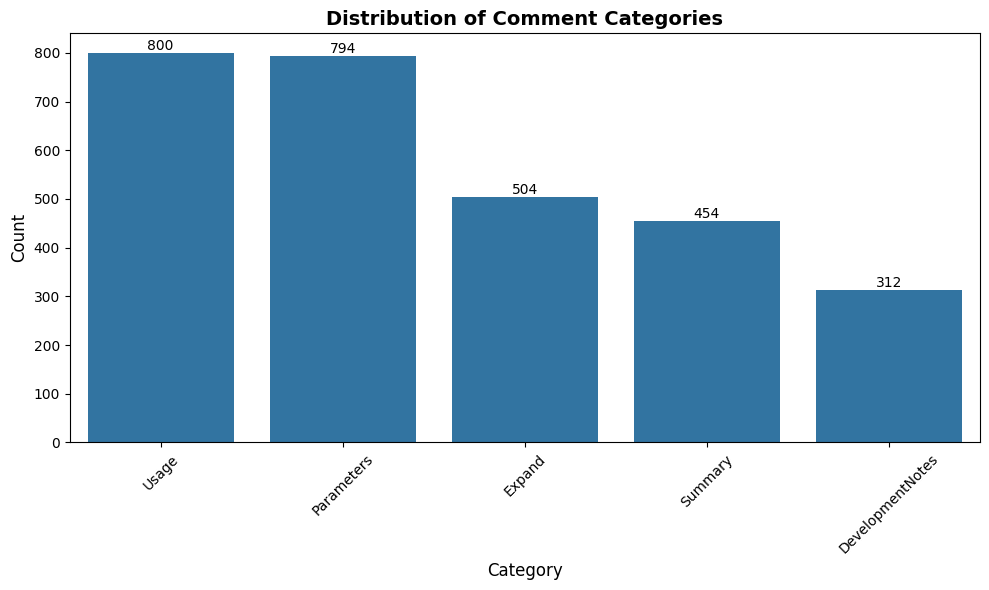

In [58]:
# Visualize category distribution
plt.figure(figsize=(10, 6))
sns.countplot(data=df_cleaned, x='category', order=df_cleaned['category'].value_counts().index)
plt.title('Distribution of Comment Categories', fontsize=14, fontweight='bold')
plt.xlabel('Category', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()

# Add count labels on bars
ax = plt.gca()
for container in ax.containers:
    ax.bar_label(container)

plt.show()

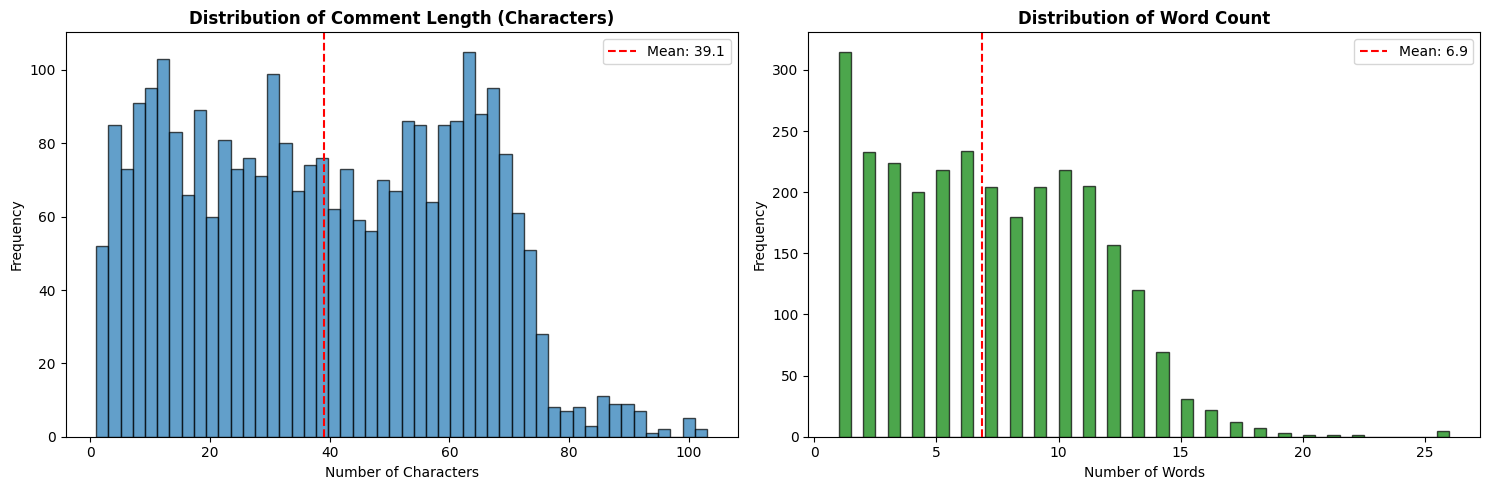

In [59]:
# Visualize text length distribution
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Character length distribution
axes[0].hist(df_cleaned['comment_length'], bins=50, edgecolor='black', alpha=0.7)
axes[0].set_title('Distribution of Comment Length (Characters)', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Number of Characters', fontsize=10)
axes[0].set_ylabel('Frequency', fontsize=10)
axes[0].axvline(df_cleaned['comment_length'].mean(), color='red', linestyle='--', 
                label=f'Mean: {df_cleaned["comment_length"].mean():.1f}')
axes[0].legend()

# Word count distribution
axes[1].hist(df_cleaned['word_count'], bins=50, edgecolor='black', alpha=0.7, color='green')
axes[1].set_title('Distribution of Word Count', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Number of Words', fontsize=10)
axes[1].set_ylabel('Frequency', fontsize=10)
axes[1].axvline(df_cleaned['word_count'].mean(), color='red', linestyle='--', 
                label=f'Mean: {df_cleaned["word_count"].mean():.1f}')
axes[1].legend()

plt.tight_layout()
plt.show()

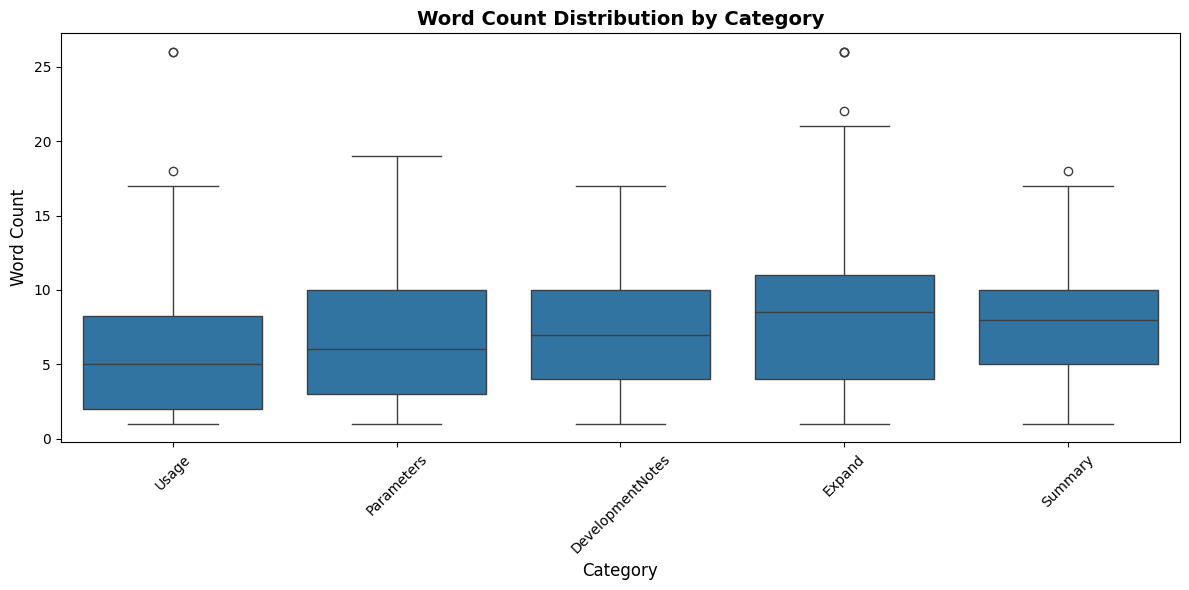

In [60]:
# Word count by category
plt.figure(figsize=(12, 6))
sns.boxplot(data=df_cleaned, x='category', y='word_count')
plt.title('Word Count Distribution by Category', fontsize=14, fontweight='bold')
plt.xlabel('Category', fontsize=12)
plt.ylabel('Word Count', fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [61]:
# Display sample comments from each category
print("Sample comments from each category:\n")
categories = sorted(df_cleaned['category'].unique())
for category in categories:
    print(f"{'='*80}")
    print(f"Category: {category}")
    print(f"{'='*80}")
    category_samples = df_cleaned[df_cleaned['category'] == category]
    if len(category_samples) > 0:
        samples = category_samples.sample(min(3, len(category_samples)))
        for idx, row in samples.iterrows():
            print(f"\nClass: {row['class']}")
            comment_text = row['comment_sentence']
            if len(comment_text) > 150:
                print(f"Comment: {comment_text[:150]}...")
            else:
                print(f"Comment: {comment_text}")
    print()

Sample comments from each category:

Category: DevelopmentNotes

Class: FollowedBy
Comment: name.

Class: TransformerEncoderLayer
Comment: ashish vaswani, noam shazeer, niki parmar, jakob uszkoreit, llion jones, aidan n gomez,

Class: _OpNamespace
Comment: then calls this new operation

Category: Expand

Class: CategoricalDtype
Comment: categories sequence, optional

Class: CategoricalDtype
Comment: methods

Class: IntegerArray
Comment: methods

Category: Parameters

Class: Audio
Comment: the original source be referenced.

Class: Environment
Comment: versionadded 22

Class: Retry
Comment: same state .

Category: Summary

Class: UnsortedIndexError
Comment: and the index has not been lexsorted.

Class: SafeFileCache
Comment: a file based cache which is safe to use even when the target directory may

Class: DummyMod
Comment: a dummy module used for ipython s interactive module when

Category: Usage

Class: MultiValueDict
Comment: d^get lastname , nonexistent

Class: BooleanArray
Comment:

In [62]:
# Display sample comments from each category
print("Sample comments from each category:\n")
categories = sorted(df_cleaned['category'].unique())
for category in categories:
    print(f"{'='*80}")
    print(f"Category: {category}")
    print(f"{'='*80}")
    category_samples = df_cleaned[df_cleaned['category'] == category]
    if len(category_samples) > 0:
        samples = category_samples.sample(min(3, len(category_samples)))
        for idx, row in samples.iterrows():
            print(f"\nClass: {row['class']}")
            comment_text = row['comment_sentence']
            if len(comment_text) > 150:
                print(f"Comment: {comment_text[:150]}...")
            else:
                print(f"Comment: {comment_text}")
    print()

Sample comments from each category:

Category: DevelopmentNotes

Class: Individual
Comment: related instances rendering will be called programmatically in this case .

Class: Markup
Comment: markup em foo &amp bar em

Class: ConfigDict
Comment: if the default value is an empty list, it is assumed to be a list of

Category: Expand

Class: BatchNorm1d
Comment: of 01.

Class: ConfigDict
Comment: 1

Class: ListMixin
Comment: function len self

Category: Parameters

Class: Environment
Comment: the size of the cache.

Class: CategoricalIndex
Comment: will be inferred from the data .

Class: Environment
Comment: out the least recently used template.

Category: Summary

Class: BuildType
Comment: checks build type.

Class: Conv3d
Comment: its own set of filters, of size

Class: KeyType
Comment: the type of a key.

Category: Usage

Class: ConfigDict
Comment: traceback most recent call last

Class: StringMethods
Comment: s^str.split

Class: NotAny
Comment: # take care not to mistake keywords for 

## 7. Save Cleaned Dataset

In [63]:
# Drop temporary statistics columns
df_to_save = df_cleaned.drop(columns=['comment_length', 'word_count'])

# Save to CSV
output_filename = 'code-comment-classification-cleaned.csv'
df_to_save.to_csv(output_filename, index=False)

print(f"Cleaned dataset saved to: {output_filename}")
print(f"Shape: {df_to_save.shape}")
print(f"Columns: {df_to_save.columns.tolist()}")

Cleaned dataset saved to: code-comment-classification-cleaned.csv
Shape: (2864, 4)
Columns: ['comment_sentence_id', 'class', 'comment_sentence', 'category']


## 8. Summary

In [64]:
# Final summary
print("="*80)
print("DATA CLEANING SUMMARY")
print("="*80)
print(f"Original dataset size: {len(df)} rows")
print(f"After removing duplicates: {len(df_no_dup)} rows")
print(f"After filtering (instance_type=1): {len(df_to_save)} rows")
print(f"\nTotal rows removed: {len(df) - len(df_to_save)}")
print(f"  - Duplicates removed: {len(df) - len(df_no_dup)}")
print(f"  - Filtered out (instance_type=0): {len(df_no_dup) - len(df_to_save)}")
print(f"\nColumns removed:")
print(f"  - instance_type (redundant after filtering)")
print(f"  - partition (using k-fold cross-validation instead)")
print(f"\nFinal dataset characteristics:")
print(f"  - Total samples: {len(df_to_save)}")
print(f"  - Unique classes: {df_to_save['class'].nunique()}")
print(f"  - Categories: {df_to_save['category'].nunique()}")
print(f"  - Category names: {sorted(df_to_save['category'].unique())}")
print(f"\nFinal columns: {df_to_save.columns.tolist()}")
print(f"  - comment_sentence_id: Unique identifier for each sentence")
print(f"  - class: Source code class name")
print(f"  - comment_sentence: The actual comment text")
print(f"  - category: Target label for classification")
print("="*80)

DATA CLEANING SUMMARY
Original dataset size: 12775 rows
After removing duplicates: 12775 rows
After filtering (instance_type=1): 2864 rows

Total rows removed: 9911
  - Duplicates removed: 0
  - Filtered out (instance_type=0): 9911

Columns removed:
  - instance_type (redundant after filtering)
  - partition (using k-fold cross-validation instead)

Final dataset characteristics:
  - Total samples: 2864
  - Unique classes: 330
  - Categories: 5
  - Category names: ['DevelopmentNotes', 'Expand', 'Parameters', 'Summary', 'Usage']

Final columns: ['comment_sentence_id', 'class', 'comment_sentence', 'category']
  - comment_sentence_id: Unique identifier for each sentence
  - class: Source code class name
  - comment_sentence: The actual comment text
  - category: Target label for classification
